# Quality Criteria

This notebook add quality criteria to the metadata which we consider to select the stations that will be part of the CAMELS-DE dataset.  
The criteria are defined in the `parameters` cell and were discussed in the CAMELS-DE consortium.  

Criteria:
- `omit_outside_of_germany` (bool): omit catchments that are located (in part) outside of the borders of Germany.
- `min_area` (float): smallest catchment area to consider [km²]
- `max_area` (float): lagest catchment area to consider [km²]
- `q_more_than_10_years` (bool): only use catchments with at least 10 years of Q data

Quality Criteria:
- `maximum_difference_to_reported_area` (float): for most of the stations, we have a reported catchment area from the metadata (from the federal states), with this parameter, we control how large the relative difference to the reported area is allowed to be. 

In [ ]:
from camelsp import get_metadata, Station

import pandas as pd
import geopandas as gpd

## Parameters / Criteria

In [2]:
min_area: float = 5. # km^2
max_area: float = 15000. # km^2
min_years_of_q: bool = 10

maximum_difference_to_reported_area: float = 0.1 # 10%

In [3]:
# initialize dataframe to store results of criteria
metadata = get_metadata()

camels_ids = metadata["camels_id"].values

# initialize dataframe with camels ids as index
df_criteria = pd.DataFrame(index=camels_ids)

## Check if merit hydro is available for the station

In [4]:
# initialize column to store if merit hydro catchment is available
df_criteria["merit_hydro_available"] = False

for camels_id in df_criteria.index.values:
    # initialize station
    s = Station(camels_id)

    # check if merit hydro catchment is available
    if s.get_catchment("merit_hydro") is not None:
        df_criteria.loc[camels_id, "merit_hydro_available"] = True

print(f"Number of stations without preselection: {len(df_criteria)}")
print(f"Number of stations with merit hydro catchment: {len(df_criteria[df_criteria['merit_hydro_available'] == True])}")

Number of stations without preselection: 2870
Number of stations with merit hydro catchment: 2824


## Check if length of Q data is minimum 10 years

Calculate which stations have at least 10 years of Q.  
Do not use `dateindex.max() - dateindex.min()` as we do not want to include NaNs, we want **10 years of values** -> 3,650 values minimum

In [5]:
# initialize column to store if minimum 10 years of discharge data are available
df_criteria[f"q_more_than_{min_years_of_q}_years"] = False


for camels_id in df_criteria.index.values:
    # initialize station
    # try:
    #     s = Station(camels_id)
    # except:
    #     print(f"Station {id} not found")
    #     continue
    s = Station(camels_id)
    # get data
    df = s.get_data()

    # count q values that are not nan
    if 'q' in df.columns:
        q_count = df['q'].count()

        # if q_count is below 3650, set flag to False, else to True
        if q_count < 365 * 10:
            df_criteria.loc[camels_id, f'q_more_than_{min_years_of_q}_years'] = False
        else:
            df_criteria.loc[camels_id, f'q_more_than_{min_years_of_q}_years'] = True
    else:
        df_criteria.loc[camels_id, f'q_more_than_{min_years_of_q}_years'] = False

print(f"Number of stations without preselection: {len(df_criteria)}")
print(f"Number of stations with more than {min_years_of_q} years of discharge data: {len(df_criteria[df_criteria[f'q_more_than_{min_years_of_q}_years'] == True])}")

Number of stations without preselection: 2870
Number of stations with more than 10 years of discharge data: 2300


## Check minimum_area < catchment_area < maximum_area 

In [6]:
# initialize column to store if catchment area is within limits
df_criteria[f"merit_area_greater_{min_area}_smaller_{max_area}"] = False

for camels_id in df_criteria.index.values:
    # initialize station
    s = Station(camels_id)

    gdf_merit = s.get_catchment("merit_hydro")

    # check if merit hydro catchment is available
    if gdf_merit is not None:
        # transform to crs in meters to calculate area
        gdf_merit = gdf_merit.to_crs(epsg=6933)
        
        # calculate area
        area_merit = gdf_merit.area.sum() / 1e6 # in km2

        # check if area is within limits
        within_limits = (area_merit >= min_area) and (area_merit <= max_area)

        df_criteria.loc[camels_id, f"merit_area_greater_{min_area}_smaller_{max_area}"] = within_limits

print(f"Number of stations without preselection: {len(df_criteria)}")
print(f"Number of stations with merit hydro catchment area within limits: {len(df_criteria[df_criteria[f'merit_area_greater_{min_area}_smaller_{max_area}'] == True])}")

Number of stations without preselection: 2870
Number of stations with merit hydro catchment area within limits: 2708


## Check if catchment is located (in parts) outside of Germany

We do not have HYRAS data outside of Germany, so we do not use these catchments for HYRAS data acquisition.

To check whether the catchment boundaries are entirely inside Germany, we use the geopackage of Germany found here: We use the geopackage from here instead: https://gdz.bkg.bund.de/index.php/default/open-data/verwaltungsgebiete-1-250-000-stand-01-01-vg250-01-01.html

The geopackage must be downloaded and placed inside the folder `input_data/assets_criteria`.

<Axes: >

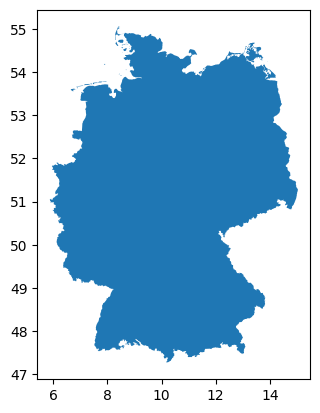

In [8]:
gdf_germany = gpd.read_file("/input_data/assets_criteria/vg250_01-01.utm32s.gpkg.ebenen/vg250_ebenen_0101/DE_VG250.gpkg")

# transform to EPSG:4326
gdf_germany = gdf_germany.to_crs(epsg=4326)

# only get the border of all the geometries in the shapefile
gdf_germany_border = gpd.GeoDataFrame(geometry=[gdf_germany.geometry.unary_union], crs=gdf_germany.crs)

gdf_germany_border.plot()

### Check if catchment is inside the borders of Germany

In [9]:
# initialize column to store if catchment area is within limits
df_criteria["merit_completely_within_germany"] = False # catchments without merit hydro catchment are False by default

for camels_id in df_criteria.index.values:
    # initialize station
    s = Station(camels_id)

    gdf_merit = s.get_catchment("merit_hydro")

    # check if merit hydro catchment is available
    if gdf_merit is not None:
        # check if catchment is completely within the borders of germany
        within_germany = gdf_merit.within(gdf_germany_border).values[0]

        df_criteria.loc[camels_id, "merit_completely_within_germany"] = within_germany

print(f"Number of stations without preselection: {len(df_criteria)}")
print(f"Number of stations with merit hydro catchment located completely in Germany: {len(df_criteria[df_criteria['merit_completely_within_germany'] == True])}")

Number of stations without preselection: 2870
Number of stations with merit hydro catchment located completely in Germany: 2414


## Check difference to reported area

In [10]:
def calculate_relative_difference_to_area_reported(area_reported: float, gdf_compare: gpd.GeoDataFrame):
    """
    Calculate the relative difference in area between a catchment and the reported area.  
    Returns None if gdf_compare is None.

    Parameters:
    -------
    area_reported : float
        Reported area of the catchment in km2.
    gdf_compare : gpd.GeoDataFrame
        GeoDataFrame of the catchment to compare.

    Returns:
    -------
    ratio_area_difference: float
        Ratio of difference in area between reported area and area of the catchment.  
        Equals 0 when the reported area is equal to the area of the catchment.

    """
    if gdf_compare is None:
        return None
    if area_reported is None or area_reported == 0:
        return None
    
    # transform to crs in meters to calculate area
    gdf_compare = gdf_compare.to_crs(epsg=6933)
        
    # calculate area
    area_compare = gdf_compare.area.sum() / 1e6 # in km2

    # Calculate the relative difference in area between the reported area and the area of the catchment
    ratio_area_difference = abs(area_reported - area_compare) / area_reported

    return ratio_area_difference


In [11]:
# initialize column to store if difference between reported and merit hydro catchment area is smaller than maximum_difference_to_reported_area
df_criteria[f"merit_difference_to_reported_area_smaller_{int(maximum_difference_to_reported_area * 100)}_percent"] = False # catchments without merit hydro catchment are False by default

for camels_id in df_criteria.index.values:
    # initialize station
    s = Station(camels_id)

    # get reported area from Station metadata
    area_reported = s.metadata["area"].values[0]

    # get merit hydro catchment
    gdf_merit = s.get_catchment("merit_hydro")

    ratio_area_difference = calculate_relative_difference_to_area_reported(area_reported, gdf_merit)

    # fill column with True if ratio_area_difference is smaller than maximum_difference_to_reported_area
    if ratio_area_difference is not None and ratio_area_difference <= maximum_difference_to_reported_area:
        df_criteria.loc[camels_id, f"merit_difference_to_reported_area_smaller_{int(maximum_difference_to_reported_area * 100)}_percent"] = True

print(f"Number of stations without preselection: {len(df_criteria)}")
print(f"Number of stations with difference between merit hydro catchment area and area reported smaller than {maximum_difference_to_reported_area}: {len(df_criteria[df_criteria[f'merit_difference_to_reported_area_smaller_{int(maximum_difference_to_reported_area * 100)}_percent'] == True])}")


Number of stations without preselection: 2870
Number of stations with difference between merit hydro catchment area and area reported smaller than 0.1: 2001


## Inspect results

### CAMELS-DE

In CAMELS-DE, we only want to include stations fulfilling the following criteria:
- MERIT Hydro catchment available
- 10 years of Q
- area between 5 and 15,000 km²
- catchment completely inside Germany (HYRAS limitation)
- Difference to the reported area max. 10 percent

In [19]:
# filter df_criteria to only contain stations that fulfill all criteria
df_criteria[
    (df_criteria["merit_hydro_available"] == True) & 
    (df_criteria[f"q_more_than_{min_years_of_q}_years"] == True) &
    (df_criteria[f"merit_area_greater_{min_area}_smaller_{max_area}"] == True) & 
    (df_criteria["merit_completely_within_germany"] == True) &
    (df_criteria[f"merit_difference_to_reported_area_smaller_{int(maximum_difference_to_reported_area * 100)}_percent"] == True)
    ]

,merit_hydro_available,q_more_than_10_years,area_within_limits,completely_within_germany,difference_to_reported_area_within_limits
DEG10000,True,True,True,True,True
DEG10010,True,True,True,True,True
DEG10020,True,True,True,True,True
DEG10030,True,True,True,False,True
DEG10050,True,True,True,True,True
...,...,...,...,...,...
DE112410,True,True,True,True,True
DE112420,True,True,True,True,True
DE112450,True,True,True,True,True
DE112480,True,True,True,True,True


### CAMELS-DE-CARAVAN

The difference between CAMELS-DE and CAMELS-DE-CARAVAN is, that we can include catchments that cross the border of Germany, as the global meteorological dataset ERA5-Land is used here, the rest of the criteria are unchanged.  
- MERIT Hydro catchment available
- 10 years of Q
- area between 5 and 15,000 km²
- Difference to the reported area max. 10 percent

In [ ]:
# filter df_criteria to only contain stations that fulfill all criteria
df_criteria[
    (df_criteria["merit_hydro_available"] == True) & 
    (df_criteria[f"q_more_than_{min_years_of_q}_years"] == True) &
    (df_criteria[f"merit_area_greater_{min_area}_smaller_{max_area}"] == True) & 
    (df_criteria[f"merit_difference_to_reported_area_smaller_{int(maximum_difference_to_reported_area * 100)}_percent"] == True)
    ]

## Add criteria columns to metadata.csv

In the last step, we add the criteria to the metadata to allow filtering for the stations we want to include in CAMELS-DE and CAMELS-DE-CARAVAN.

In [ ]:
# read metadata.csv
meta = pd.read_csv("/camelsp/output_data/metadata/metadata.csv")

# set index name of df_criteria to "camels_id" to allow easy merging with metadata
df_criteria.index.name = "camels_id"

# identify columns in df_criteria that are not in meta
new_columns = [col for col in df_criteria.columns if col not in meta.columns]

# join only new columns
merged = meta.join(df_criteria[new_columns], on="camels_id", how="left")

# save merged dataframe to csv
merged.to_csv("/camelsp/output_data/metadata/metadata.csv", index=False)

In [ ]:
get_metadata()